In [1]:
import matplotlib
import pinocchio as pin
from pinocchio import casadi as cpin
import casadi
import numpy as np
import example_robot_data as robex 
import matplotlib.pyplot as plt
from pinocchio.visualize import GepettoVisualizer
import pandas as pd
import seaborn as sns
import random

plt.style.use('seaborn')

In [12]:
robot = robex.load('solo12')
model = robot.model
data = model.createData()

In [13]:
try:
    viz = pin.visualize.GepettoVisualizer(robot.model,robot.collision_model,robot.visual_model)
    viz.initViewer()
    viz.loadViewerModel()
    viz.display(robot.q0)
except:
    viz=None


In [14]:
def ground(xy):
    '''Ground altitude as a function of x-y position'''
    #return (xy[0]/5+xy[1]/8) * 0 # Flat terrain
    #return (xy[0]/5+xy[1]/8)
    #return xy[0]/1+xy[1]/1
    return (np.sin(xy[0]*3)/5 + np.cos(xy[1]**2*3)/20 + np.sin(xy[1]*xy[0]*5)/10)
    #return xy[0]**2/10 - xy[1]**2/20 + xy[0]*xy[1]/15 + .3*xy[0] + .15*xy[1]

In [15]:
def vizGround(viz,elevation,space,name='ground',color=[1,1,1,1]):
    space = 1e-1
    gv = viz.viewer.gui
    for i,x in enumerate(np.arange(-1,1,space)):
        gv.deleteNode(f'world/pinocchio/visuals/{name}_cx{i}',True)
        gv.addCurve(f'world/pinocchio/visuals/{name}_cx{i}',
                    [ [x,y,elevation([x,y])] for y in np.arange(-1,1,space) ], color)
    for i,y in enumerate(np.arange(-1,1,space)):
        gv.deleteNode(f'world/pinocchio/visuals/{name}_cy{i}',True)
        gv.addCurve(f'world/pinocchio/visuals/{name}_cy{i}',
                    [ [x,y,elevation([x,y])] for x in np.arange(-1,1,space) ], color)

if viz is not None: vizGround(viz,ground,.1,color=[1,1,1,1])

In [16]:
cxyz = casadi.SX.sym("xyz",3,1)
groundNormal = casadi.Function('groundNormal',[cxyz],[casadi.gradient(cxyz[2]-ground(cxyz[:2]),cxyz)])

feet = { idx: f.name for idx,f in enumerate(model.frames) if 'FOOT' in f.name }
mass = sum( [ y.mass for y in model.inertias ] )
grav = np.linalg.norm(model.gravity.linear)

In [17]:
### ACTION MODEL
class MX2SX:
    length = .3  # pendulum elongated dimension
    def __init__(self,model):
        self.cmodel = cmodel = cpin.Model(model)
        self.cdata = cdata = cmodel.createData()

        cq = casadi.SX.sym("q",model.nq,1)
        cdq = casadi.SX.sym("dq",model.nv,1)

        cpin.framesForwardKinematics(self.cmodel,self.cdata,cq)
        self.feet = \
            { idx: casadi.Function(f'{name}_pos', [cq], [cdata.oMf[idx].translation])  for idx,name in feet.items() }

        self.com = casadi.Function('com',[cq],[cpin.centerOfMass(cmodel,cdata,cq)])

        self.integrate = casadi.Function('integrate',[ cq,cdq ],[cpin.integrate(cmodel,cq,cdq) ])

In [52]:
# Here an optimization problem is solved with the specified parameters
def run_opti(constraint_type = 0, dq0_warm_start = None, fs0_warm_start = None, eps = 1e-8):
    opti = casadi.Opti()
    mx2sx = MX2SX(model)

    # Decision variables
    dq = opti.variable(model.nv)
    q = mx2sx.integrate(robot.q0,dq)
    fs = [ opti.variable(3) for _ in feet.values() ]

    # constraint the com_xy position
    opti.subject_to(mx2sx.com(q)[:2] == np.array([.1,.2]))
    rq = q[7:]-robot.q0[7:]
    totalcost = rq.T@rq

    for f in mx2sx.feet.values():
        opti.subject_to( f(q)[2] == ground(f(q)[:2]) )  ### Foot in contact with the ground

    torque = 0
    com = mx2sx.com(q)
    for idx,force in zip(mx2sx.feet.keys(),fs):
        pos = mx2sx.feet[idx](q)
        perp = groundNormal(pos)

        if (constraint_type == 0):
            normal = perp/ casadi.norm_2(perp) 
            fn = force.T@normal # This one is the magnitude of the normal component
            ft = force - fn*normal # The force vector - the vector of the normal force
            opti.subject_to(  ft.T@ft <= fn.T@fn  )   # force in friction cone normal to ground (classic method)

        elif (constraint_type == 1):
            #fp = (force@perp.T@perp- force.T @ perp@perp) # Should be equivalen
            fp = (force@perp.T@perp- perp@perp.T@force)
            opti.subject_to( fp.T@fp <=  (perp.T@force@force.T@perp@perp.T@perp))

        elif (constraint_type == 2):
            opti.subject_to( force.T@perp >= np.sqrt( 1/2 * (force.T@force)@(perp.T@perp) + eps) )
        else:
            raise ValueError("Please select a valid type of friction constraint")
            

        #opti.subject_to(  force.T@force <= (mass*grav)**2 )   ### norm of force below total mass (abritrary)

        torque += casadi.cross(force,pos-com)
        
    opti.subject_to( sum(fs) == np.array([ 0,0,mass*grav ]))  ### sum of forces is weight
    opti.subject_to( torque == 0 )  ### sum of torques around COM is 0
    totalcost += sum( [ f.T@f for f in fs ] )/10

    opti.subject_to( mx2sx.com(q)[2] >= (sum([ f(q)[2] for f in mx2sx.feet.values() ])+ 1e-6 *0 )/len(feet))

    ### SOLVE
    opti.minimize(totalcost)

    if dq0_warm_start: opti.set_initial(dq, dq0_warm_start)
    if fs0_warm_start: [opti.set_initial(fs[i], fs0_warm_start[i]) for i in range(4)]

    opti.solver("ipopt") # set numerical backend
    sol = opti.solve_limited()

    dqopt = opti.value(dq)
    qopt = opti.value(q)
    fsopt = [opti.value(f) for f in fs]
    inf_du = sol.stats()['iterations']['inf_du']
    inf_pr = sol.stats()['iterations']['inf_pr']

    return {'dqopt': dqopt, 'qopt': qopt, 'fsopt': fsopt, 'inf_pr': inf_pr, 'inf_du': inf_du}

In [69]:
residuals = {'inf_du': [], 'inf_pr': [], 'obj': []}
qopt_log = []
dqopt_log = []
fsopt_log = []

for i in range(3):
    opti_res = run_opti(i, eps=1e-8)
    if(i == 0):
        dq0_ws = [q for q in opti_res['dqopt']]
        fs0_ws = opti_res['fsopt']
        
    dqopt_log += [opti_res['dqopt']]
    qopt_log += [opti_res['qopt']]
    fsopt_log += [opti_res['fsopt']]
    residuals['inf_pr'] += [opti_res['inf_pr']]
    residuals['inf_du'] += [opti_res['inf_du']]

qopt_log = np.array(qopt_log)
fsopt_log = np.array(fsopt_log).reshape(3,12)

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       66
Number of nonzeros in Lagrangian Hessian.............:      357

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

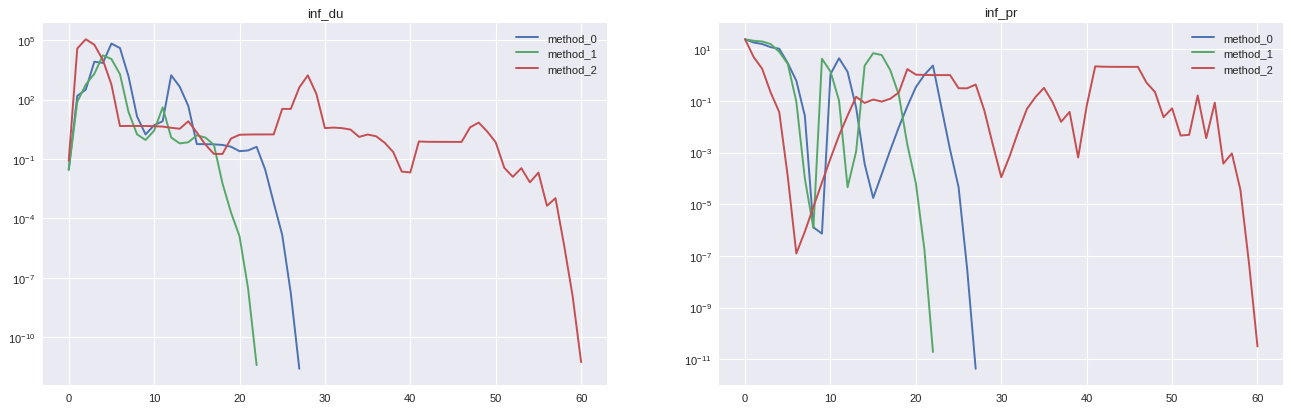

In [65]:
legend = []   
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1,2,1)
plt.title('inf_du')
for i in range(3):
    legend += ['method_' + str(i)]
    plt.semilogy(residuals['inf_du'][i])    
plt.legend(legend)

plt.subplot(1,2,2)
legend = []   
plt.title("inf_pr")
for i in range(3):
    legend += ['method_' + str(i)]
    plt.semilogy(residuals['inf_pr'][i])    
plt.legend(legend)
plt.show()

# Visualize the differences between 3 methods

In [66]:
columns = []
for i in range (4):
    columns.append('F_' + str(i) + '_x')
    columns.append('F_' + str(i) + '_y')
    columns.append('F_' + str(i) + '_z')

for i in range(qopt_log.shape[1]):
    columns.append('q_' + str(i))
    
labels = ['method0', 'method1', 'method2']
    

In [67]:
data_vector = np.concatenate([fsopt_log, qopt_log], axis = 1)
df = pd.DataFrame(data_vector, columns=columns)
df.insert(0, "label",  labels)
df

,label,F_0_x,F_0_y,F_0_z,F_1_x,F_1_y,F_1_z,F_2_x,F_2_y,F_2_z,...,q_9,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18
0,method0,0.148538,-0.00946,6.0036,0.206835,-0.008196,5.69178,-0.198171,0.009759,6.452107,...,-1.395784,-0.324326,1.151448,-1.567296,0.024032,-0.66743,1.510494,-0.012109,-0.611158,1.608815
1,method1,0.148538,-0.00946,6.0036,0.206835,-0.008196,5.69178,-0.198171,0.009759,6.452107,...,-1.395784,-0.324326,1.151448,-1.567296,0.024032,-0.66743,1.510494,-0.012109,-0.611158,1.608815
2,method2,0.148538,-0.00946,6.0036,0.206835,-0.008196,5.69178,-0.198171,0.009759,6.452107,...,-1.395784,-0.324326,1.151448,-1.567296,0.024032,-0.66743,1.510494,-0.012109,-0.611158,1.608815


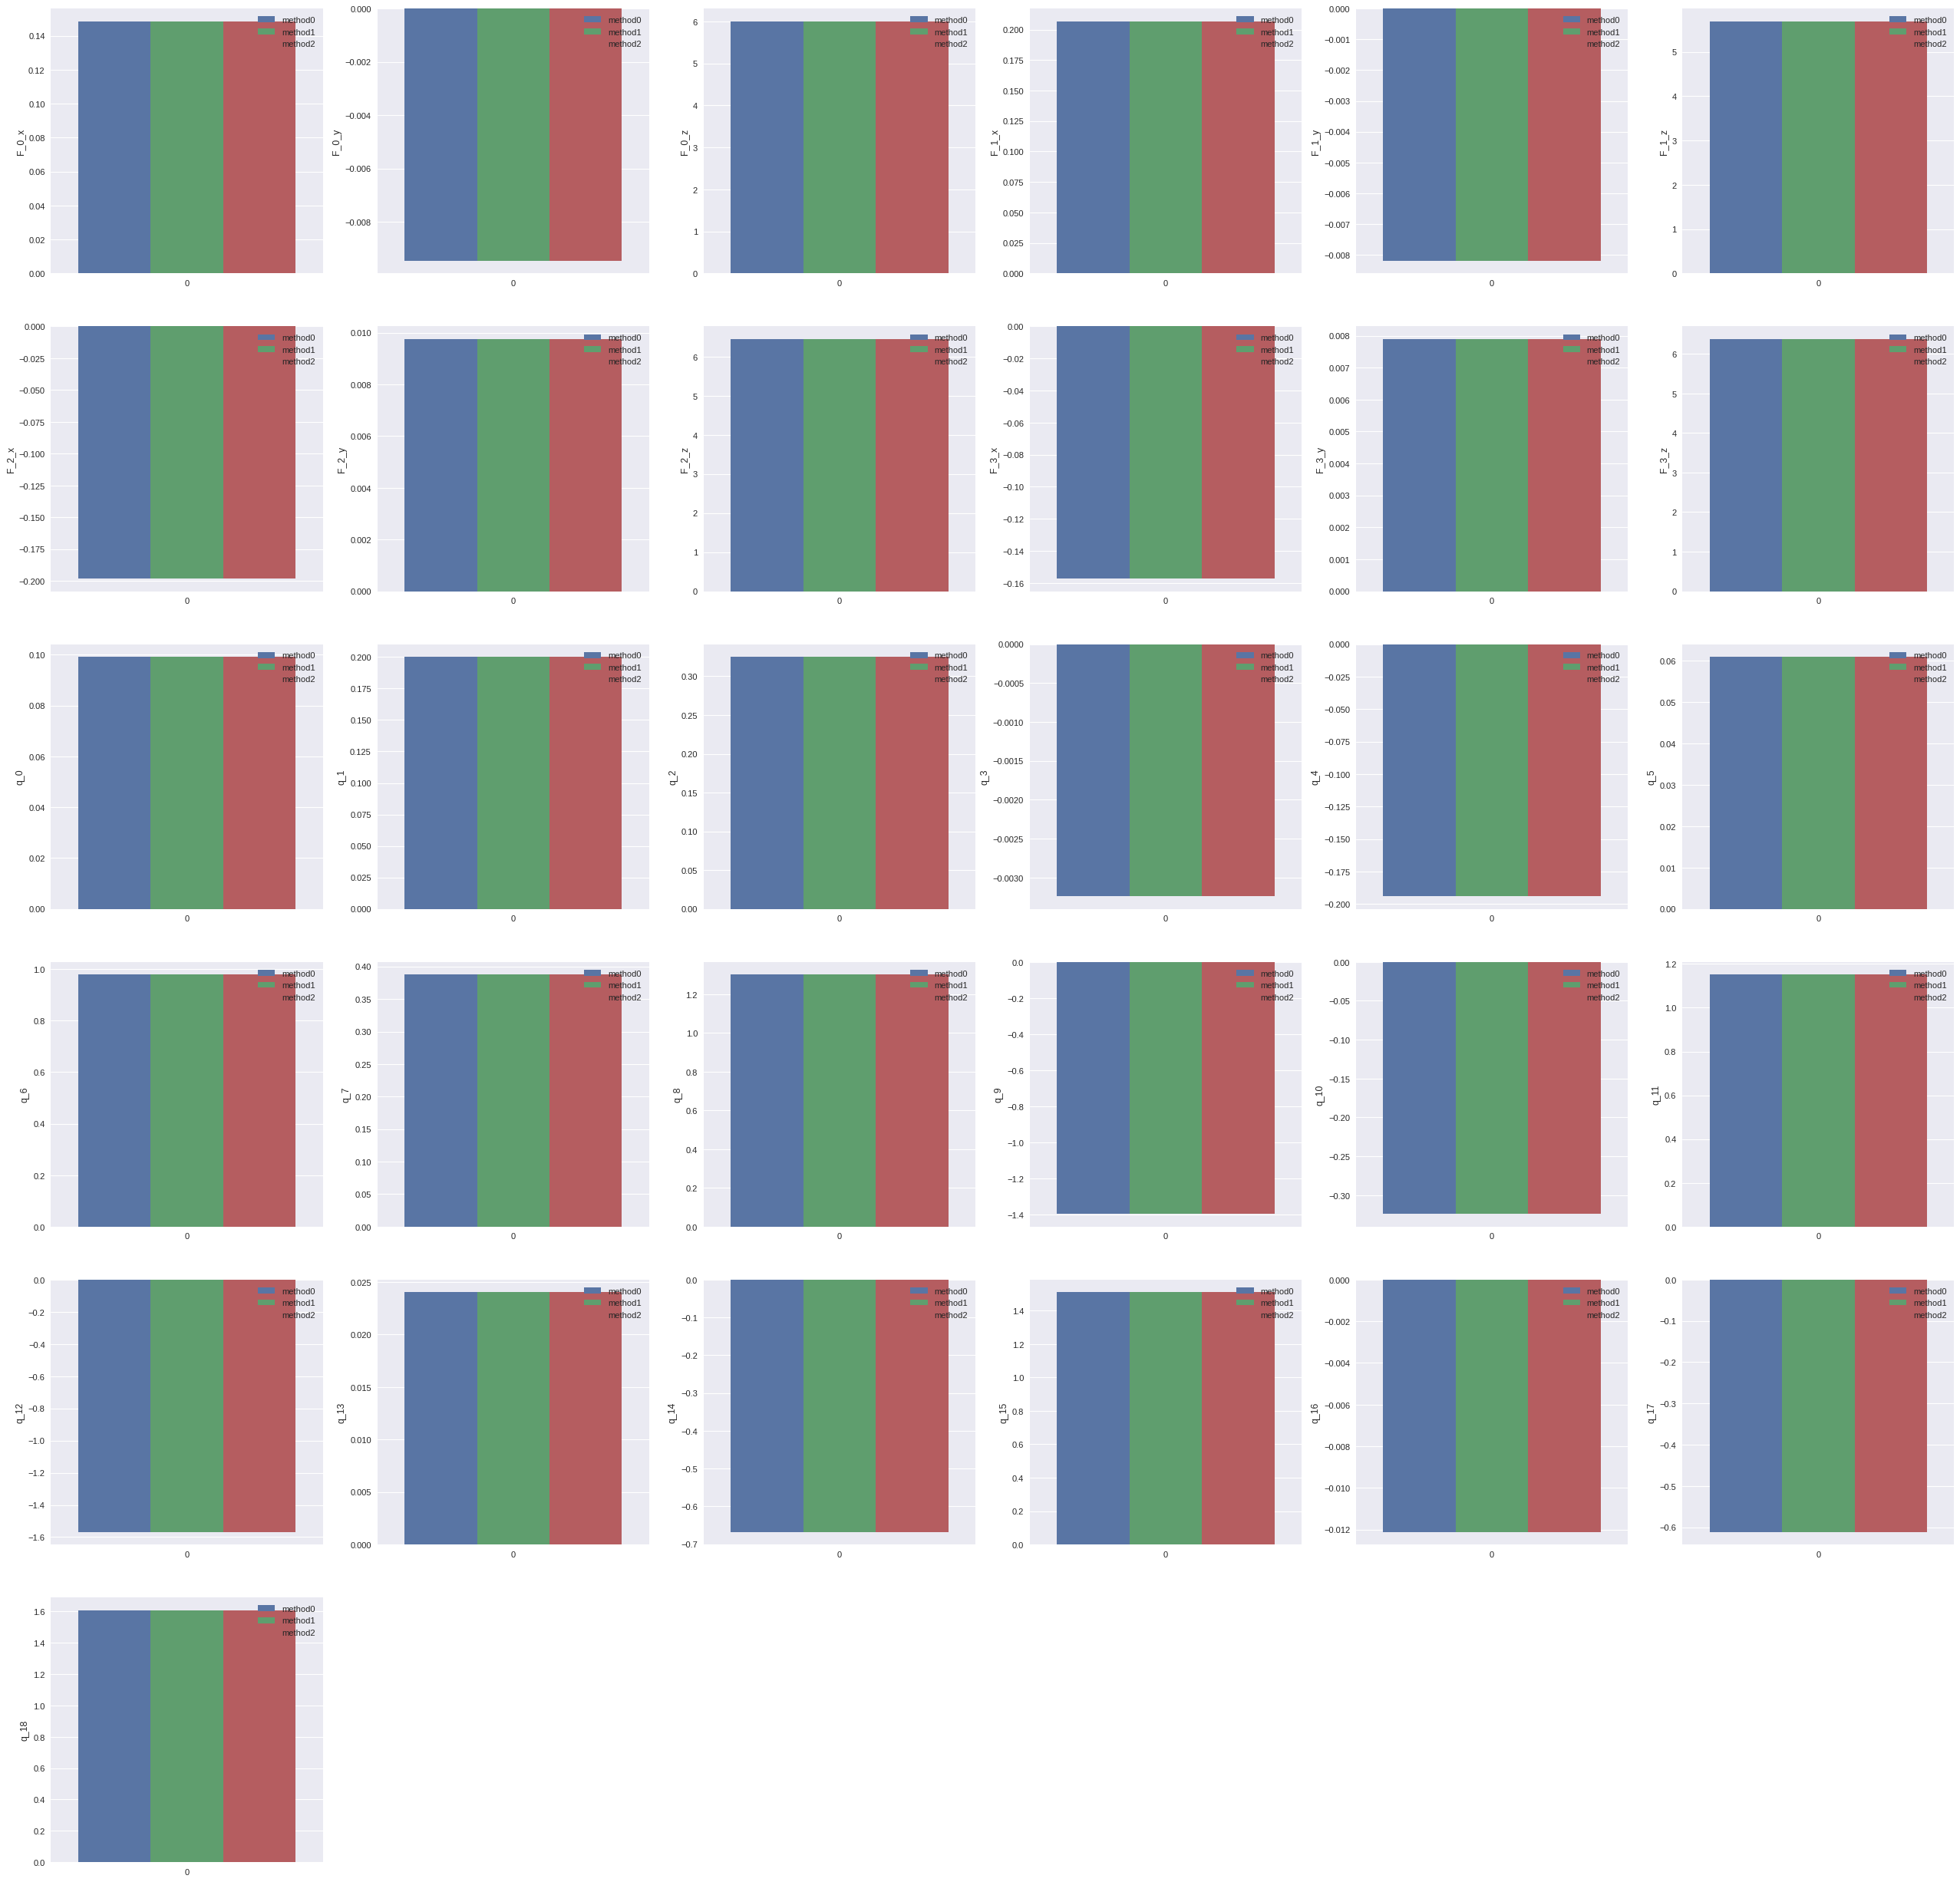

In [51]:
plt.figure(figsize=(40, 40), dpi=80)
for i in range(len(columns)):
    plt.subplot(6, 6, i+1)
    sns.barplot(x= [0,0,0], y= columns[i], hue = labels, data = df)

# Try again with warm start

In [80]:
residuals_ws = {'inf_du': [], 'inf_pr': [], 'obj': []}
qopt_log_ws = []
dqopt_log_ws = []
fsopt_log_ws = []

for i in range(3):
    opti_res = run_opti(i, dq0_warm_start=dq0_ws, eps=1e-8) # now we can also remove the epsilon (if we give also guesses for forces)

    dqopt_log_ws += [opti_res['dqopt']]
    qopt_log_ws += [opti_res['qopt']]
    fsopt_log_ws += [opti_res['fsopt']]
    residuals_ws['inf_pr'] += [opti_res['inf_pr']]
    residuals_ws['inf_du'] += [opti_res['inf_du']]

qopt_log_ws = np.array(qopt_log_ws)
fsopt_log_ws = np.array(fsopt_log_ws).reshape(3,12)

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:       66
Number of nonzeros in Lagrangian Hessian.............:      357

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:        5
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        5

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

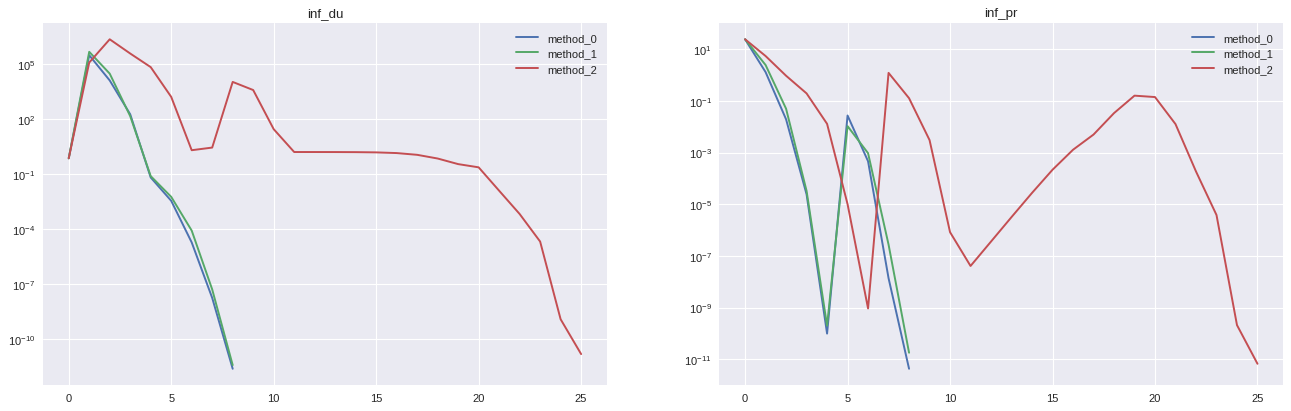

In [81]:
legend = []   
plt.figure(figsize=(20, 6), dpi=80)
plt.subplot(1,2,1)
plt.title('inf_du')
for i in range(3):
    legend += ['method_' + str(i)]
    plt.semilogy(residuals_ws['inf_du'][i])    
plt.legend(legend)

plt.subplot(1,2,2)
legend = []   
plt.title("inf_pr")
for i in range(3):
    legend += ['method_' + str(i)]
    plt.semilogy(residuals_ws['inf_pr'][i])    
plt.legend(legend)
plt.show()

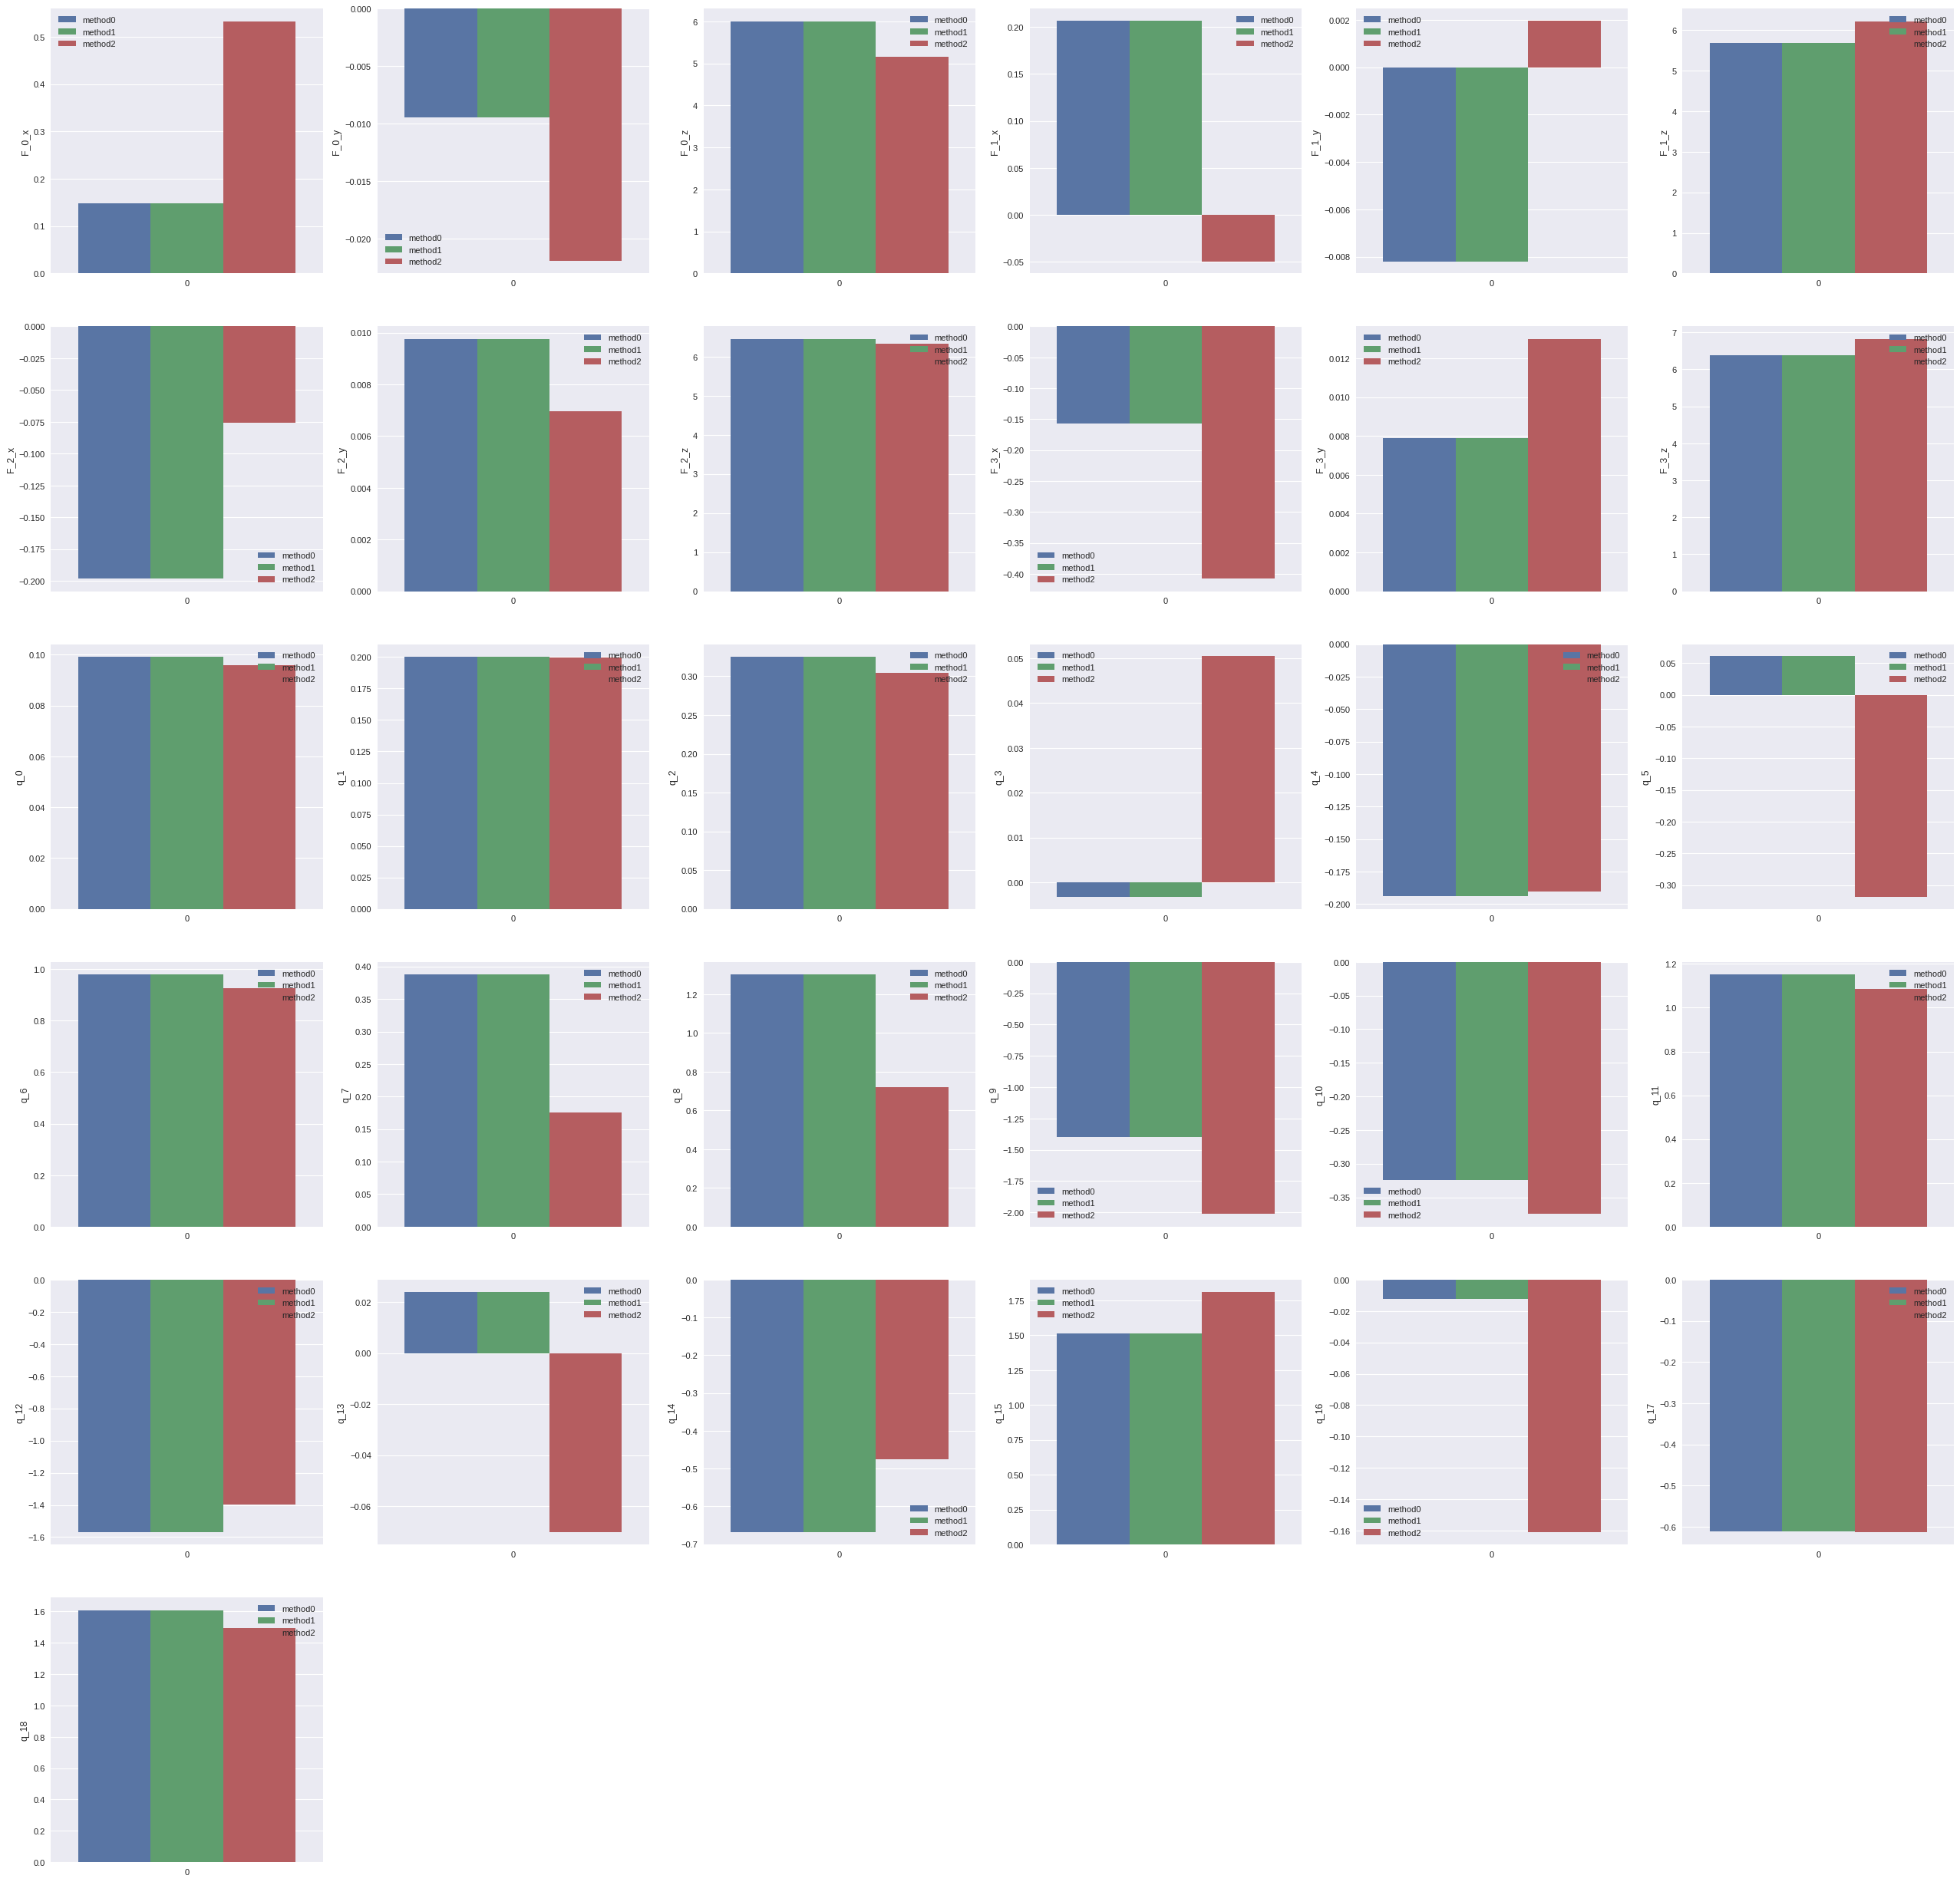

In [82]:
columns = []
for i in range (4):
    columns.append('F_' + str(i) + '_x')
    columns.append('F_' + str(i) + '_y')
    columns.append('F_' + str(i) + '_z')

for i in range(qopt_log.shape[1]):
    columns.append('q_' + str(i))
    
labels = ['method0', 'method1', 'method2']

data_vector = np.concatenate([fsopt_log_ws, qopt_log_ws], axis = 1)
df = pd.DataFrame(data_vector, columns=columns)
df.insert(0, "label",  labels)

plt.figure(figsize=(40, 40), dpi=80)
for i in range(len(columns)):
    plt.subplot(6, 6, i+1)
    sns.barplot(x= [0,0,0], y= columns[i], hue = labels, data = df)